<a href="https://colab.research.google.com/github/DLesmes/bert_embeddings_generator/blob/main/bert_embedding_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Requirements

In [1]:
!pip install datasets
# embeddings
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from concurrent.futures import ThreadPoolExecutor
# data
from datasets import load_dataset
import pandas as pd
import numpy as np
# nn
import torch.nn as nn
from sklearn.metrics import accuracy_score
import seaborn as sns

# Embedding Model

In [2]:
# Choose a suitable pre-trained BERT model
model_name = 'bert-base-uncased'

# Load the model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)
embed_model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Data

In [3]:
dataset = load_dataset("tasksource/mmlu", "international_law")
dataset

DatasetDict({
    test: Dataset({
        features: ['question', 'choices', 'answer'],
        num_rows: 121
    })
    validation: Dataset({
        features: ['question', 'choices', 'answer'],
        num_rows: 13
    })
    dev: Dataset({
        features: ['question', 'choices', 'answer'],
        num_rows: 5
    })
})

In [4]:
%%time
data_train = []
data_test = []
data_val = []

for question in dataset['test']:
  row = { "text" : question['question']
          + " " + question['choices'][0]
          + " " + question['choices'][1]
          + " " + question['choices'][2]
          + " " + question['choices'][3],
          "result": question['answer']
  }
  data_train.append(row)

for question in dataset['validation']:
  row = { "text" : question['question']
          + " " + question['choices'][0]
          + " " + question['choices'][1]
          + " " + question['choices'][2]
          + " " + question['choices'][3],
          "result": question['answer']
  }
  data_test.append(row)



for question in dataset['dev']:
  row = { "text" : question['question']
          + " " + question['choices'][0]
          + " " + question['choices'][1]
          + " " + question['choices'][2]
          + " " + question['choices'][3],
          "result": question['answer']
  }
  data_val.append(row)

CPU times: user 13.9 ms, sys: 887 µs, total: 14.8 ms
Wall time: 15.8 ms


In [5]:
df_train = pd.DataFrame(data_train)
df_test = pd.DataFrame(data_test)
df_val = pd.DataFrame(data_val)
dfs = [df_train, df_test, df_val]
for df in dfs:
  print(df.shape)

(121, 2)
(13, 2)
(5, 2)


In [6]:
df_train.head()

,text,result
0,Which State ordinarily exercises jurisdiction ...,1
1,What is the meaning of justiciability? Justici...,0
2,In what way is Responsibility to Protect (R2P)...,2
3,What is the 'Lotus principle'? The so-called L...,0
4,Which of these statements best describes the U...,2


In [7]:
df_test.head()

,text,result
0,What kind of passage does qualify as 'innocent...,1
1,What kind of State practice is required? Wides...,0
2,Which treaties are considered as 'source of in...,1
3,What is the 'optional; clause' in the ICJ Stat...,2
4,Can armed violence perpetrated by non-State ac...,1


In [8]:
def embed(text: list):
  # Tokenize and encode the text
  inputs = tokenizer(text, return_tensors='pt', padding=True)

  # Pass the input through the model (no fine-tuning needed)
  with torch.no_grad():
      outputs = embed_model(**inputs)

  # Extract the embeddings
  return outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding


In [9]:
%%time
for df in dfs:
  embed_list = embed(df['text'].to_list())
  df['X'] = [embedding for embedding in embed_list]
  print(df.shape)

(121, 3)
(13, 3)
(5, 3)
CPU times: user 44.4 s, sys: 14.1 s, total: 58.5 s
Wall time: 1min 10s


In [10]:
df_train.head()

,text,result,X
0,Which State ordinarily exercises jurisdiction ...,1,"[tensor(-0.2486), tensor(-0.2092), tensor(-0.0..."
1,What is the meaning of justiciability? Justici...,0,"[tensor(-0.5092), tensor(-0.3899), tensor(-0.7..."
2,In what way is Responsibility to Protect (R2P)...,2,"[tensor(-0.4645), tensor(-0.6626), tensor(-0.3..."
3,What is the 'Lotus principle'? The so-called L...,0,"[tensor(-0.2778), tensor(-0.5422), tensor(-0.6..."
4,Which of these statements best describes the U...,2,"[tensor(0.0603), tensor(0.2212), tensor(-0.117..."


In [11]:
df_test.head()

,text,result,X
0,What kind of passage does qualify as 'innocent...,1,"[tensor(-0.4748), tensor(-0.3957), tensor(-0.1..."
1,What kind of State practice is required? Wides...,0,"[tensor(-0.1644), tensor(0.1313), tensor(-0.40..."
2,Which treaties are considered as 'source of in...,1,"[tensor(-0.2643), tensor(-0.0352), tensor(-0.5..."
3,What is the 'optional; clause' in the ICJ Stat...,2,"[tensor(-0.2463), tensor(-0.2587), tensor(-0.4..."
4,Can armed violence perpetrated by non-State ac...,1,"[tensor(-0.3789), tensor(-0.3413), tensor(-1.0..."


In [12]:
len(df_test.X[0])

768

In [13]:
X_train = np.array(df_train.X.tolist())
X_test = np.array(df_test.X.tolist())
y_train = np.array(df_train.result)
y_test = np.array(df_test.result)

In [14]:
X_train.shape

(121, 768)

In [15]:
X_test.shape

(13, 768)

In [16]:
y_train.shape

(121,)

In [17]:
y_test.shape

(13,)

# NN - Model

In [18]:
y_train.shape[0]

121

In [19]:
class il_mmlu_data(Dataset):
  def __init__(self, X_train, y_train) -> None:
        super().__init__()
        self.X = X_train
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]

  def __getitem__(self, index):
      return self.X[index], self.y[index]

  def __len__(self):
      return self.len


In [20]:
# %% dataloader
il_mmlu_dataset = il_mmlu_data(X_train=X_train, y_train=y_train)
train_loader = DataLoader(dataset=il_mmlu_dataset, batch_size=32)

In [21]:
class nn_text_classifier(nn.Module):
  def __init__(
      self,
      num_features,
      num_classes,
      first_hidden_features,
      second_hidden_features
  ):
    super().__init__()
    self.ln1 = nn.Linear(
        num_features,
        first_hidden_features
    )
    self.ln2 = nn.Linear(
        first_hidden_features,
        second_hidden_features
    )
    self.ln3 = nn.Linear(
        second_hidden_features,
        num_classes
    )
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.ln1(x)
    x = torch.sigmoid(x)
    x = self.ln2(x)
    x = torch.sigmoid(x)
    x = self.ln3(x)
    x = self.log_softmax(x)
    return x




In [22]:
num_features = 768
num_classes = 4
first_hidden_features = 348
second_hidden_features = 192
model = nn_text_classifier(
    num_features=num_features,
    num_classes=num_classes,
    first_hidden_features=first_hidden_features,
    second_hidden_features=second_hidden_features
)

# Train loop

In [23]:
criterion = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
epochs = 1000

In [24]:
%%time
losses = []
for epoch in range(epochs):
  for X, y in train_loader:
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
  losses.append(float(loss.data.detach().numpy()))

CPU times: user 9.08 s, sys: 99.6 ms, total: 9.18 s
Wall time: 9.26 s


Text(0.5, 1.0, 'Loss vs Epochs')

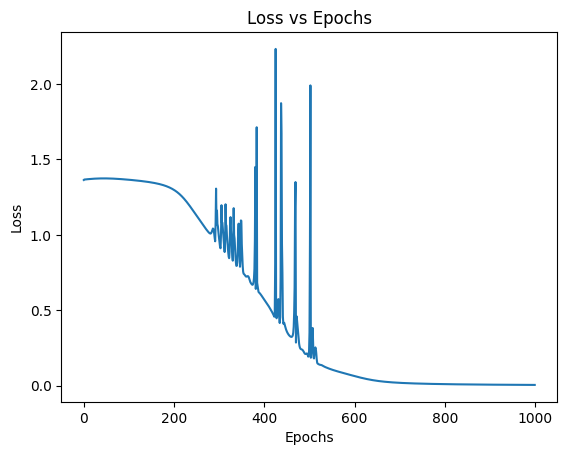

In [25]:
# prompt: add title to the axis of this graph "sns.lineplot(x= range(len(losses)), y = losses)"

import matplotlib.pyplot as plt
sns.lineplot(x= range(len(losses)), y = losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')


In [26]:
# %% test the model
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    y_test_hat_softmax = model(X_test_torch)
    y_test_hat = torch.max(y_test_hat_softmax.data, 1)

In [27]:
# %% Accuracy
accuracy_score(y_test, y_test_hat.indices)

0.23076923076923078